# Notebook to train a DNN for trump selection

### Libraries

We use the keras library for building, training and evaluating the network. A tutorial for keras can be found on (https://keras.io/) or https://www.tensorflow.org/guide/keras. There are different implementations of keras, here I will use the one build on tensorflow.


In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

In [2]:

path_to_data = Path('data')
# Import only a fraction of data for efficient testing
data = pd.read_csv(path_to_data / '2018_10_18_trump.csv', header=None)
cards = [
# Diamonds
'DA','DK','DQ','DJ','D10','D9','D8','D7','D6',
# Hearts
'HA','HK','HQ','HJ','H10','H9','H8','H7','H6',
# Spades
'SA','SK','SQ','SJ','S10','S9','S8','S7','S6',
# Clubs
'CA','CK','CQ','CJ','C10','C9','C8','C7','C6'
]

# Forehand (yes = 1, no = 0)
forehand = ['FH']

user  = ['user']
trump = ['trump']

data.columns = cards + forehand + user + trump
print(data.columns)
data.drop((data['trump']==6).index[:1],inplace=True)
data['trump'].value_counts()

Index(['DA', 'DK', 'DQ', 'DJ', 'D10', 'D9', 'D8', 'D7', 'D6', 'HA', 'HK', 'HQ',
       'HJ', 'H10', 'H9', 'H8', 'H7', 'H6', 'SA', 'SK', 'SQ', 'SJ', 'S10',
       'S9', 'S8', 'S7', 'S6', 'CA', 'CK', 'CQ', 'CJ', 'C10', 'C9', 'C8', 'C7',
       'C6', 'FH', 'user', 'trump'],
      dtype='object')


6    137553
5     44653
2     40115
3     39756
4     35829
1     31087
0     30831
Name: trump, dtype: int64

In [14]:
#Drop rows where the player didn't play more than 50 games
play_count = data['user'].value_counts()
data = data[data.user != 0]
data = data[~data['user'].isin(play_count[play_count < 1].index)]
data['user'].value_counts()
data.drop('user', axis='columns', inplace=True)

In [15]:
data['trump'].value_counts()

6    102362
5     33192
2     29467
3     29209
4     26467
0     22352
1     22320
Name: trump, dtype: int64

In [16]:

# print(data['trump'].value_counts())
# data_trump = data.copy([data['trump']==6])
# print(data['trump'].value_counts())
# data = data[data.trump != 6]
#
# data_trump.drop(data_trump.index[:15000],inplace = True)
#
#
# data = data.append(data_trump,ignore_index=True)
#
# print(data['trump'].value_counts())

In [17]:
data.trump = data.trump.astype('category')
data[cards + forehand] = data[cards + forehand].astype(bool)
#data.trump.cat.rename_categories({6: 10}, inplace=True)

data.head()

data.trump.value_counts()
trump = data.pop('trump')
print(trump.unique())
y_train = tf.keras.utils.to_categorical(trump)

print(y_train.shape)

[5, 6, 4, 1, 2, 3, 0]
Categories (7, int64): [5, 6, 4, 1, 2, 3, 0]
(265369, 7)


In [18]:
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CA,CK,CQ,CJ,C10,C9,C8,C7,C6,FH
1,False,False,False,False,False,False,False,False,True,True,...,False,False,False,True,False,False,False,True,False,False
2,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,True,False
3,False,False,False,False,False,False,False,False,False,True,...,True,False,False,False,True,True,False,False,False,False
4,False,True,False,False,False,False,False,False,True,True,...,False,False,False,True,False,False,False,False,False,True
5,False,False,True,False,False,False,True,False,True,False,...,True,False,False,False,False,False,False,False,False,True


In [19]:
from tensorflow.keras import regularizers
model = keras.Sequential()
model.add(keras.layers.Dense(37, activation='relu', input_shape=[37]))
model.add(keras.layers.Dense(100, activation="relu"
,kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.3)),
model.add(keras.layers.Dense(100, activation="relu"
,kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.3)),
model.add(keras.layers.Dense(100, activation="relu"
,kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.3)),
model.add(keras.layers.Dense(100, activation="relu"
,kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.3)),
model.add(keras.layers.Dense(7, activation='softmax'))


lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=len(data)*1000,
  decay_rate=1,
  staircase=False)



model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              metrics=['accuracy'])

In [20]:
print(data.shape)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(data.values, y_train, validation_split=0.25, epochs=80, batch_size=5000,
              callbacks =[early_stop])

(265369, 37)
Epoch 1/80
40/40 [==============================] - 2s 25ms/step - loss: 2.0792 - accuracy: 0.3702 - val_loss: 1.9110 - val_accuracy: 0.3868
Epoch 2/80
40/40 [==============================] - 1s 13ms/step - loss: 1.7679 - accuracy: 0.4284 - val_loss: 1.4546 - val_accuracy: 0.5352
Epoch 3/80
40/40 [==============================] - 0s 12ms/step - loss: 1.4395 - accuracy: 0.5339 - val_loss: 1.1713 - val_accuracy: 0.6031
Epoch 4/80
40/40 [==============================] - 1s 13ms/step - loss: 1.2493 - accuracy: 0.5791 - val_loss: 1.0674 - val_accuracy: 0.6227
Epoch 5/80
40/40 [==============================] - 1s 14ms/step - loss: 1.1614 - accuracy: 0.5959 - val_loss: 1.0244 - val_accuracy: 0.6311
Epoch 6/80
40/40 [==============================] - 1s 14ms/step - loss: 1.1168 - accuracy: 0.6017 - val_loss: 0.9932 - val_accuracy: 0.6350
Epoch 7/80
40/40 [==============================] - 1s 18ms/step - loss: 1.0809 - accuracy: 0.6091 - val_loss: 0.9720 - val_accuracy: 0.6390


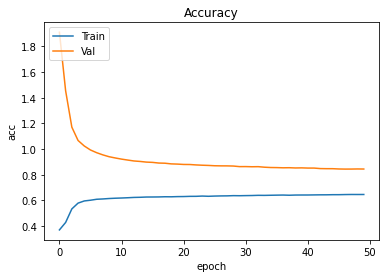

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['Train', 'Val'], loc='upper left')




In [22]:
model.save('models/v3')


INFO:tensorflow:Assets written to: models/v3\assets


INFO:tensorflow:Assets written to: models/v3\assets
